Load Packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
pip install catboost

In [ ]:
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False


Read the data.

In [ ]:
data_df = pd.read_csv("creditcard.csv")

Check the data.

In [ ]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 5965  columns: 31


Glimpse the data.

In [ ]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991389847235408,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.48909501589608,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717292731410831,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507756869957169,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.3458515932154,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5965.000000,5964.000000,5964.000000,5964.000000,5963.000000,5963.000000,5963.000000,5963.000000,5963.000000,5963.000000,5963.000000,5962.000000
mean,5315.260017,-0.225383,0.279916,0.869528,0.155308,-0.063037,0.046045,0.013173,-0.062226,0.499747,-0.189564,0.518287,-0.562623,0.353027,0.066194,-0.063087,0.090265,-0.019894,-0.020157,0.028835,-0.008220,-0.087690,-0.047704,0.020688,0.090715,0.145341,0.017496,0.011825,61.049753,0.002516
std,5313.464273,1.446019,1.259760,1.135715,1.426574,1.220608,1.268012,1.114753,1.181314,1.122167,1.048533,1.192327,1.475228,1.224421,0.942367,0.872239,0.987532,0.938134,0.784318,0.563882,0.819329,0.600345,0.426214,0.589936,0.414554,0.581433,0.385642,0.561155,191.247543,0.050100
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,-13.193415,-2.595325,-17.769143,-19.214325,-4.092344,-12.227189,-18.587366,-6.920762,-4.021062,-12.834042,-11.273890,-5.707801,-11.669994,-2.203341,-2.483069,-1.338556,-5.336289,-3.509250,0.000000,0.000000
25%,1161.000000,-0.979179,-0.166270,0.381999,-0.716749,-0.617114,-0.681495,-0.472671,-0.188070,-0.257084,-0.632981,-0.347492,-1.794339,-0.178485,-0.505228,-0.531424,-0.387550,-0.431508,-0.479406,-0.141656,-0.226618,-0.470190,-0.189317,-0.320918,-0.139877,-0.296676,-0.084125,-0.016579,4.805000,0.000000
50%,2532.000000,-0.378752,0.296881,0.900441,0.173182,-0.167451,-0.188520,0.016658,0.016665,0.462152,-0.298910,0.468444,-0.131768,0.288871,0.177112,0.029307,0.038986,0.004366,-0.031966,-0.019868,-0.075988,-0.052209,-0.059796,0.084425,0.121136,0.073725,0.005158,0.015929,15.950000,0.000000
75%,11353.000000,1.146061,0.863979,1.500938,0.996969,0.341209,0.414045,0.542460,0.252971,1.279163,0.141643,1.372822,0.514785,1.169264,0.735573,0.497657,0.510810,0.419701,0.457844,0.147773,0.066204,0.300007,0.057719,0.416200,0.357025,0.626252,0.141633,0.081116,48.000000,0.000000
max,14864.000000,1.960497,8.636214,4.017561,10.463020,34.099309,21.393069,34.303177,5.060381,7.496577,11.906868,12.018913,3.774837,4.197010,3.635042,4.087802,7.893393,41.710000,4.555359,7.744222,15.631453,4.393846,10.475770,2.192626,2.419792,3.463246,8.254376,39.000000,7712.430000,1.000000


Check missing data.

In [ ]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V16,V19,V18,V17,Time,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,V15
Total,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.050293,0.033529,0.033529,0.033529,0.033529,0.033529,0.033529,0.033529,0.016764,0.016764,0.016764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data unbalance

In [ ]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

Data Exploration

In [ ]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [ ]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0.0,0.00,7712.43,3960,256531.16,64.780596,12.99,45627.208851
1,0.0,1.0,0.00,529.00,2,529.00,264.500000,264.50,139920.500000
2,1.0,0.0,3.55,730.32,9,1078.53,119.836667,27.43,55112.948225
3,3.0,0.0,0.00,1903.26,1591,84597.78,53.172709,15.95,16622.778605
4,3.0,1.0,0.00,179.66,13,220.05,16.926923,1.00,2457.208190


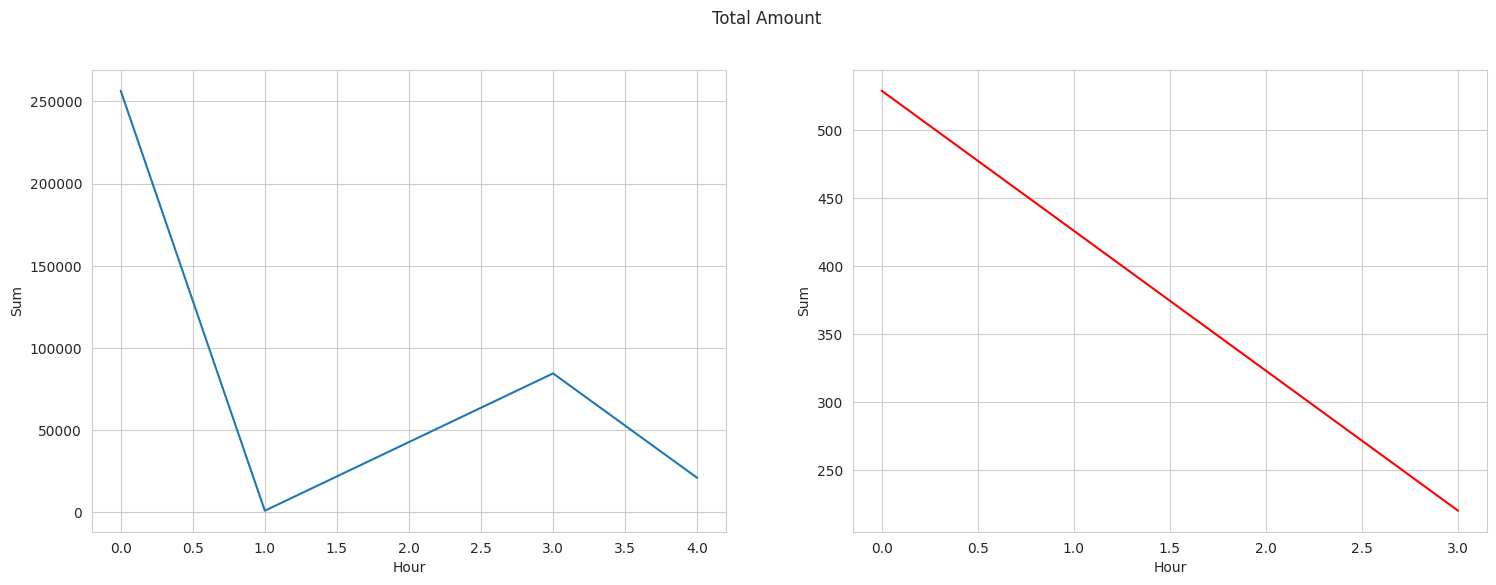

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

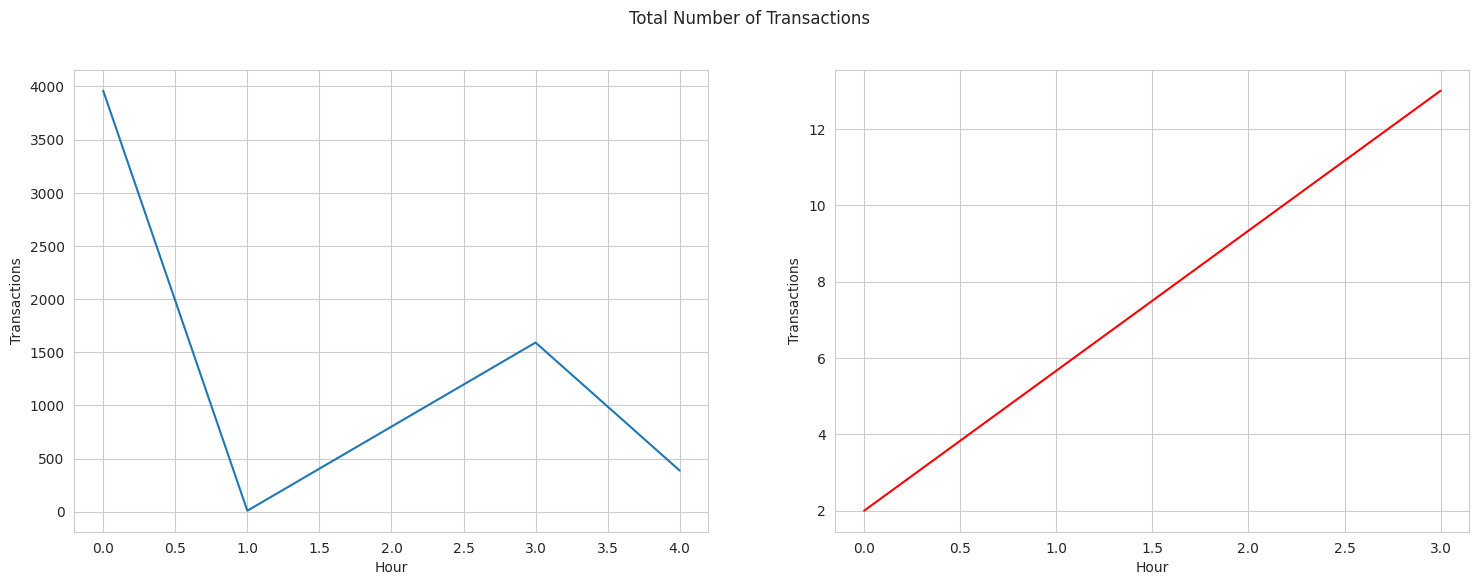

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

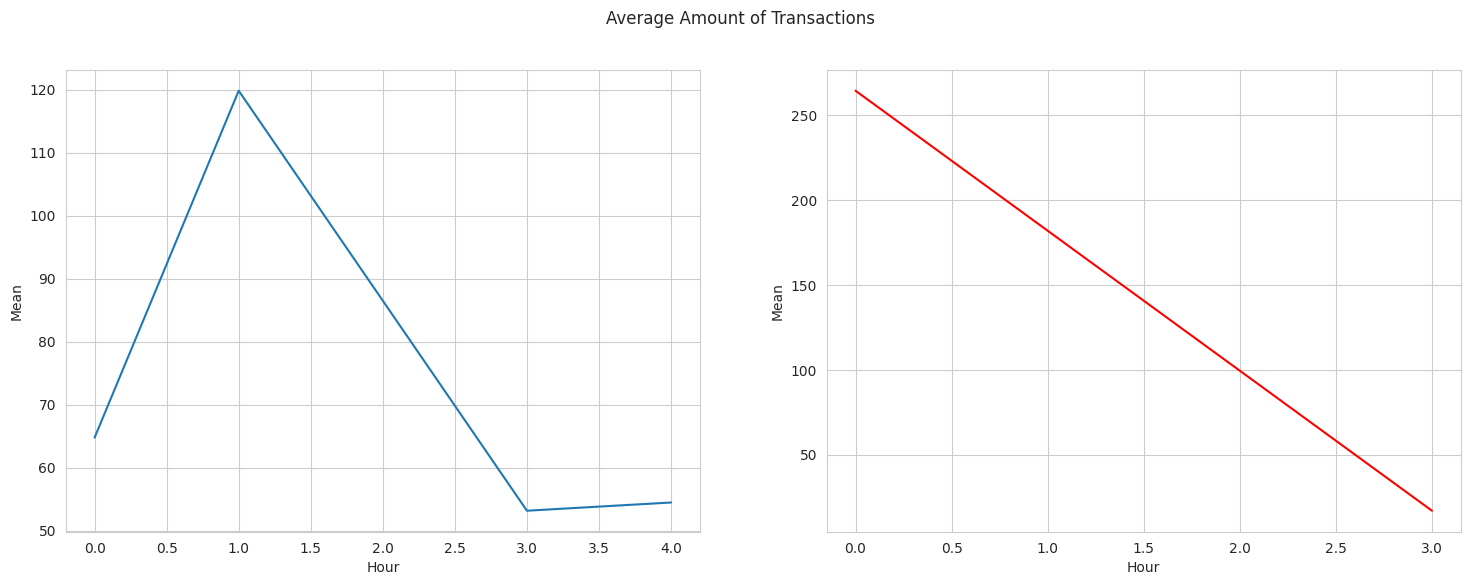

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

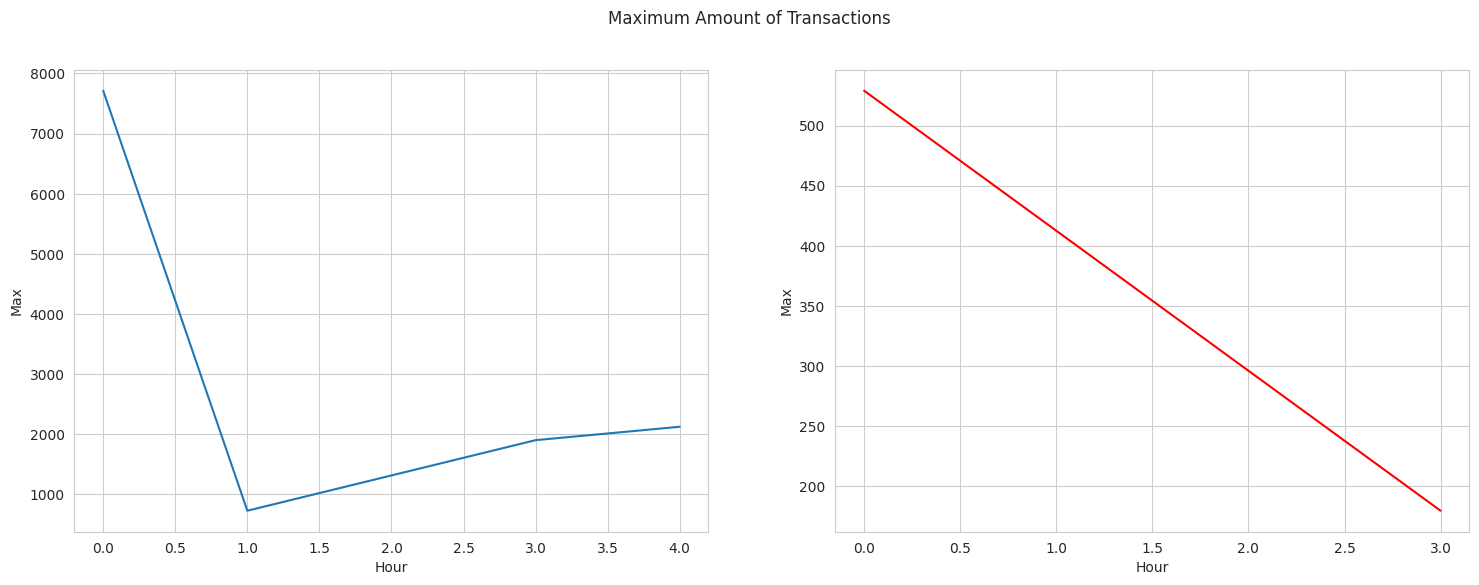

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

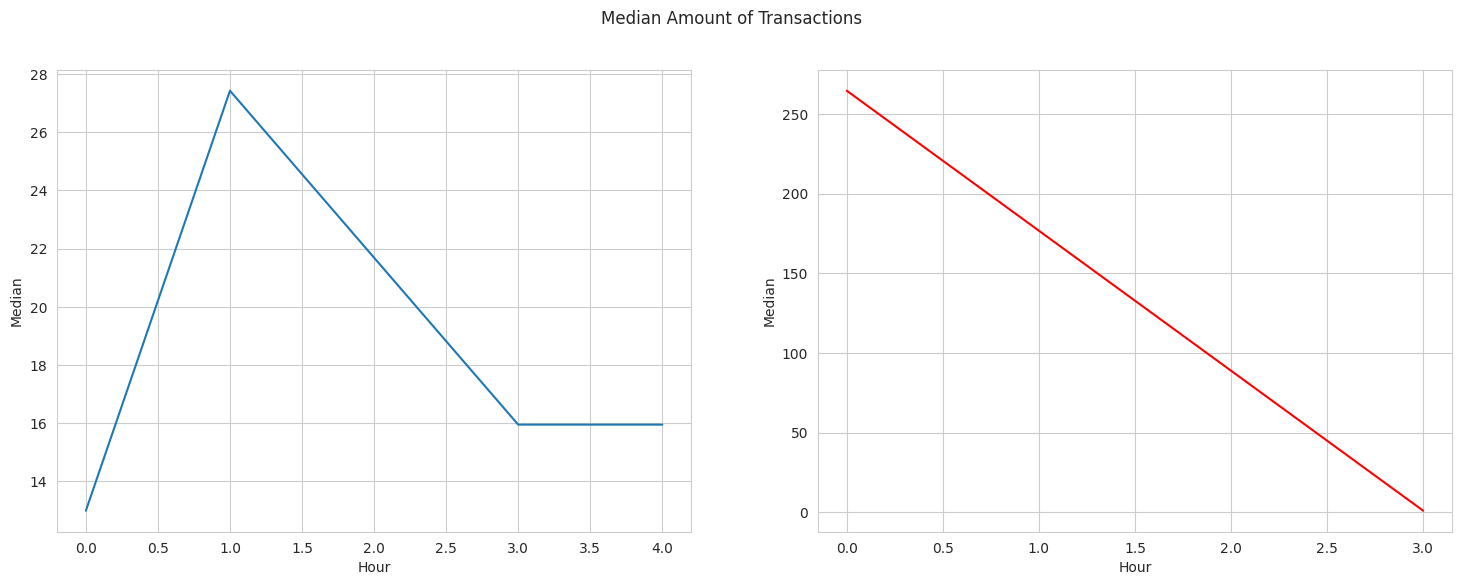

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

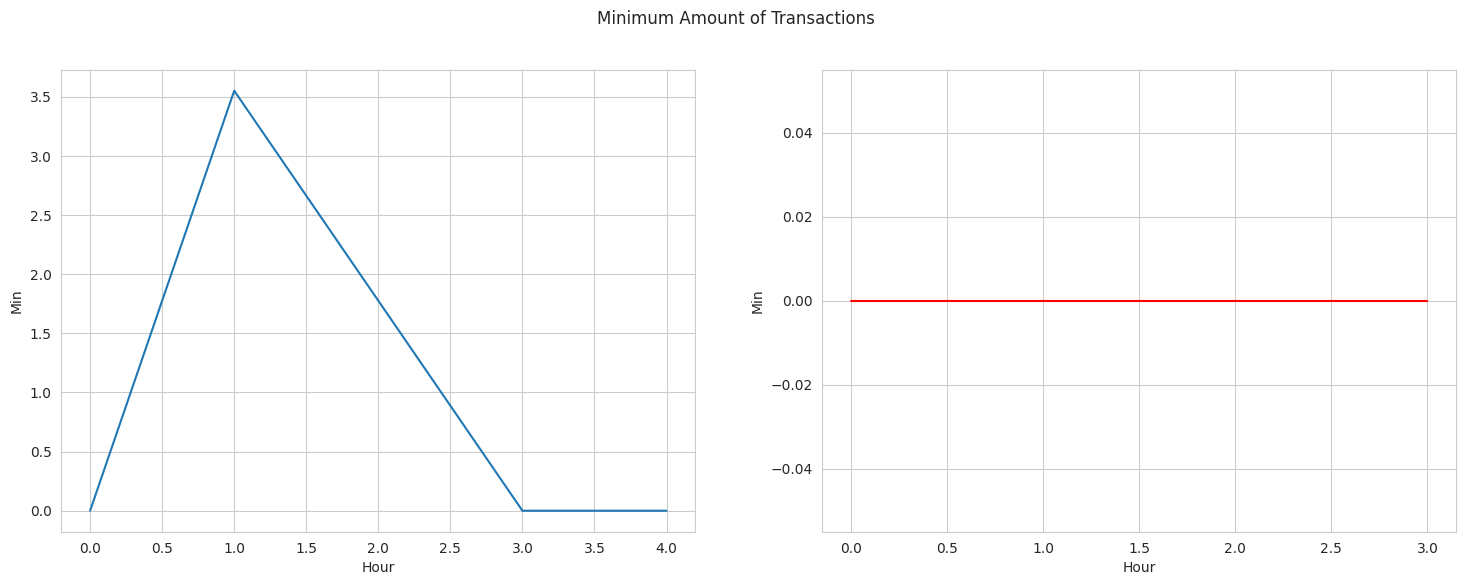

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

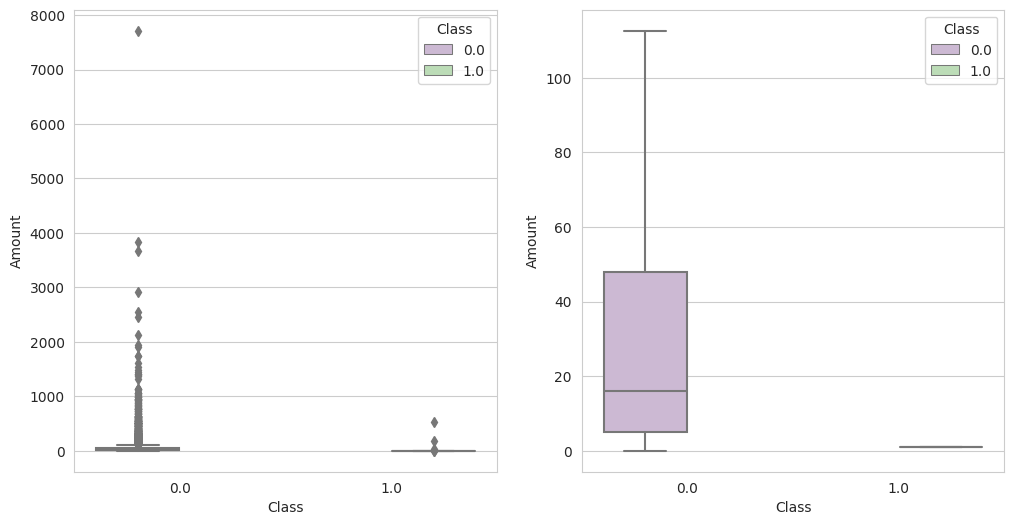

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [ ]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    5947.000000
mean       61.088049
std       191.381152
min         0.000000
25%         4.900000
50%        15.950000
75%        48.000000
max      7712.430000
Name: Amount, dtype: float64

In [ ]:
class_1.describe()

count     15.000000
mean      49.936667
std      140.317804
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      529.000000
Name: Amount, dtype: float64

In [ ]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

<ipython-input-136-7d24d93ff160>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



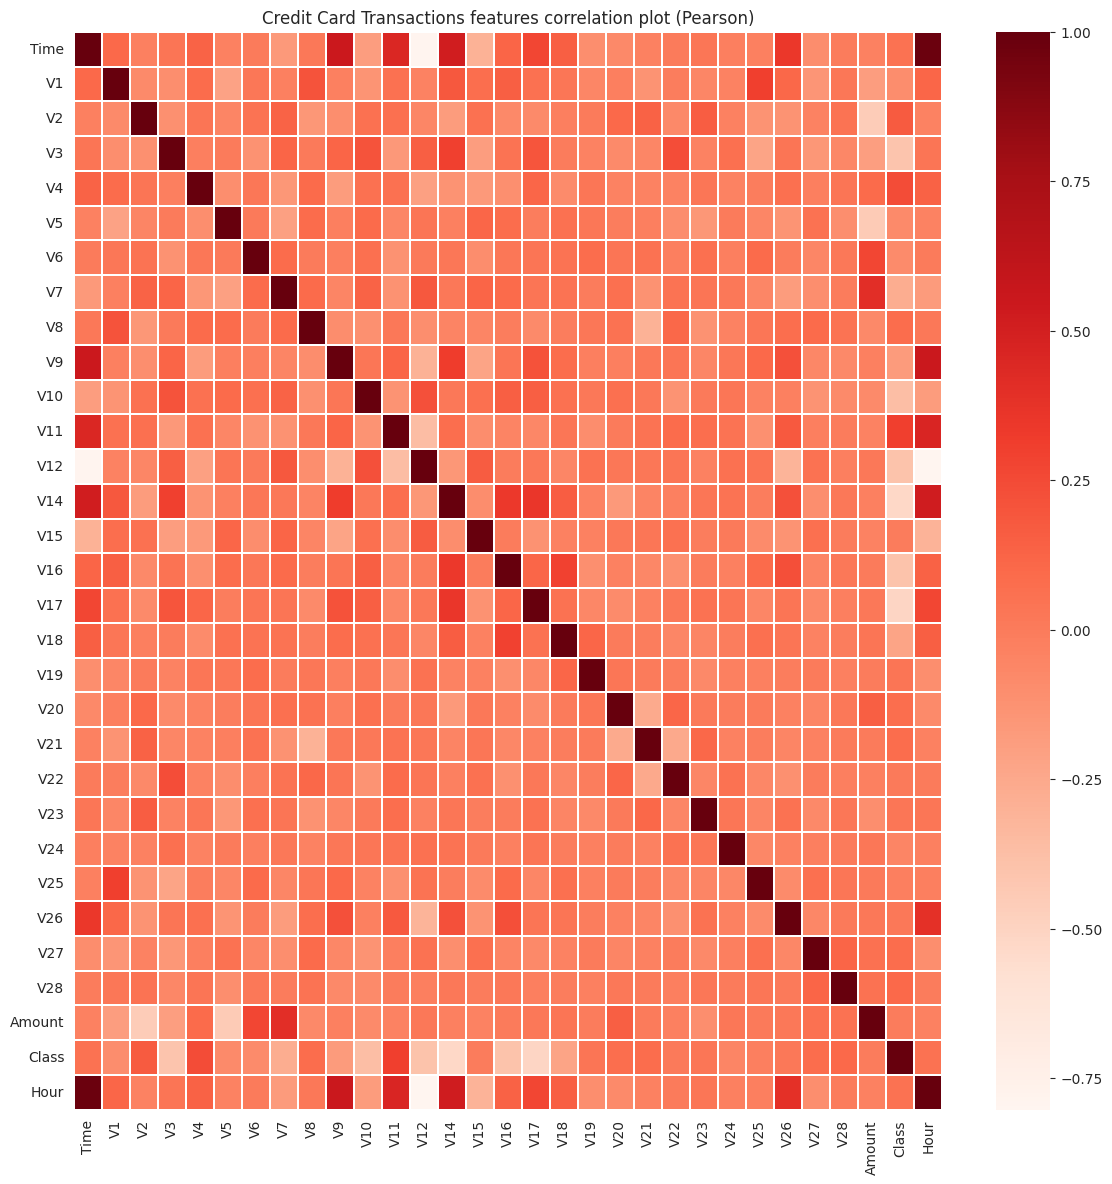

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

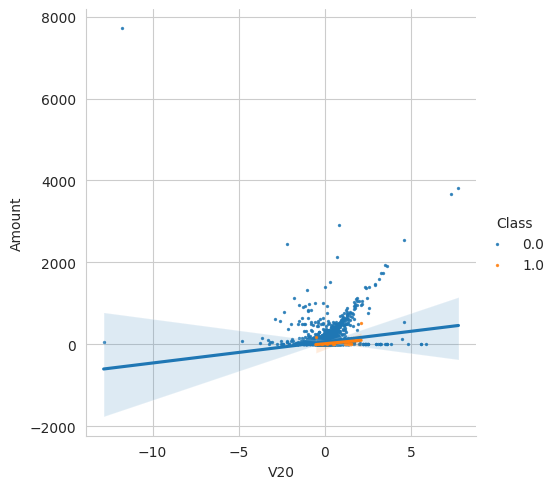

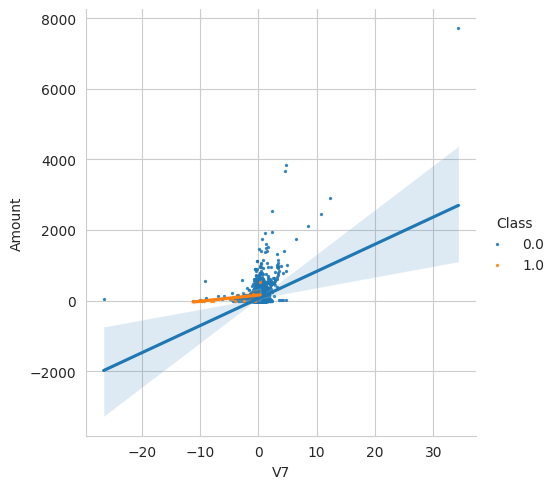

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

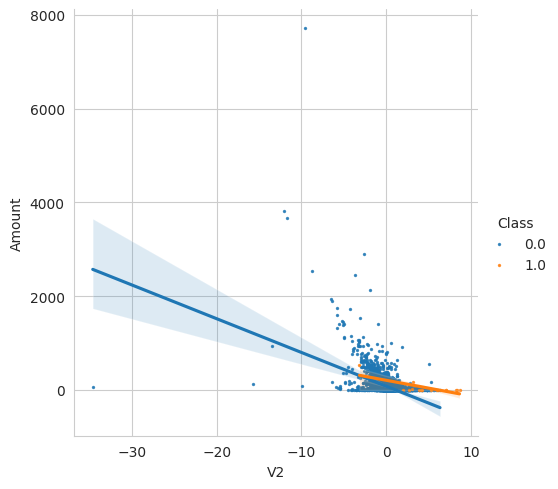

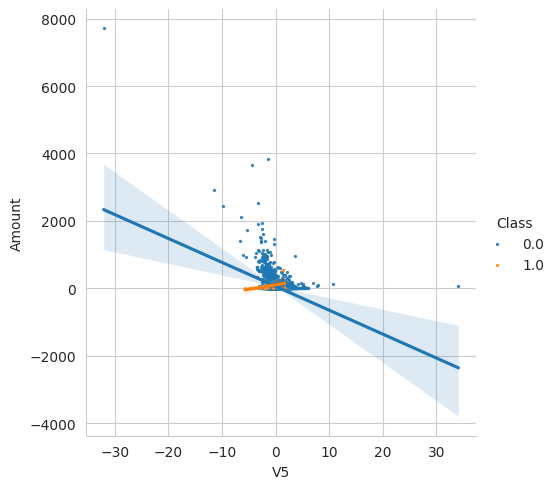

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Predictive models

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [ ]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [ ]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

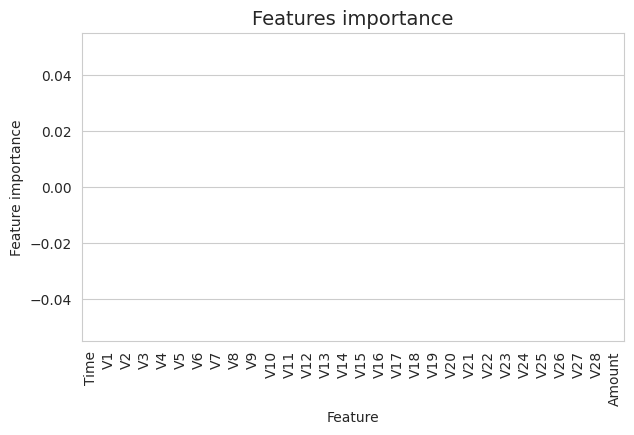

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }


In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score,
                            precision_score, recall_score,
                            f1_score, matthews_corrcoef,
                            confusion_matrix)

In [ ]:
credit = pd.read_csv('creditcard.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991389847235408,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.48909501589608,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717292731410831,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507756869957169,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.3458515932154,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
# Descriptive statistical measures of the dataset
credit.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,5965.0,5315.260017,5313.464273,0.000000,1161.000000,2532.000000,11353.000000,14864.000000
V1,5965.0,-0.225383,1.446019,-27.670569,-0.979179,-0.378752,1.146061,1.960497
V2,5965.0,0.279916,1.259760,-34.607649,-0.166270,0.296881,0.863979,8.636214
V3,5965.0,0.869528,1.135715,-15.496222,0.381999,0.900441,1.500938,4.017561
V4,5965.0,0.155308,1.426574,-4.657545,-0.716749,0.173182,0.996969,10.463020
V5,5965.0,-0.063037,1.220608,-32.092129,-0.617114,-0.167451,0.341209,34.099309
V6,5965.0,0.046045,1.268012,-23.496714,-0.681495,-0.188520,0.414045,21.393069
V7,5965.0,0.013173,1.114753,-26.548144,-0.472671,0.016658,0.542460,34.303177
V8,5965.0,-0.062226,1.181314,-23.632502,-0.188070,0.016665,0.252971,5.060381
V9,5965.0,0.499747,1.122167,-6.329801,-0.257084,0.462152,1.279163,7.496577


In [ ]:
# Determine number of fraud cases in the dataset
fraud = credit[credit['Class'] == 1]
valid = credit[credit['Class'] == 0]
fraction = len(fraud)/float(len(valid))

print(fraction)
print("Fraud Cases: {}".format(len(credit[credit['Class'] == 1])))
print("Valid Cases: {}".format(len(credit[credit['Class'] == 0])))

0.002522280141247688
Fraud Cases: 15
Valid Cases: 5947


In [ ]:
# Print the amount of details for Fraudulent Transaction
print("Amount of details for the Fraudulent Transaction")
fraud.Amount.describe()

Amount of details for the Fraudulent Transaction


count     15.000000
mean      49.936667
std      140.317804
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      529.000000
Name: Amount, dtype: float64

In [ ]:
# Print the amount of details for Normal Transaction
print("Amount of details for Normal Transaction")
valid.Amount.describe()

Amount of details for Normal Transaction


count    5947.000000
mean       61.088049
std       191.381152
min         0.000000
25%         4.900000
50%        15.950000
75%        48.000000
max      7712.430000
Name: Amount, dtype: float64

<ipython-input-153-229881793660>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



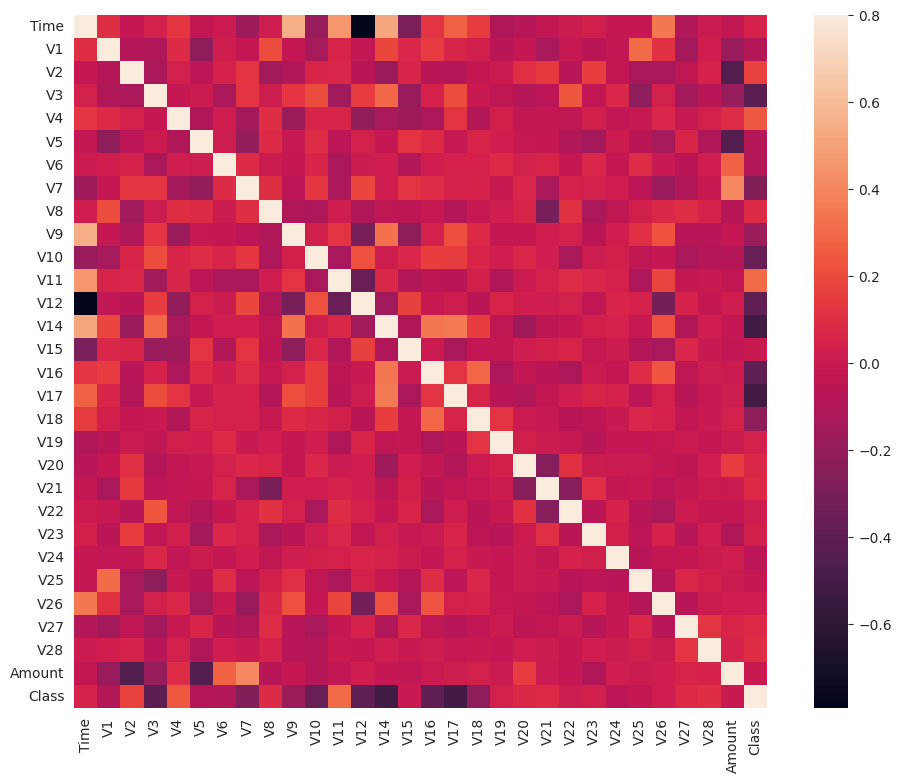

In [ ]:
# Plotting the Correlation Matrix
corrmat = credit.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [ ]:
# dividing X and Y from the dataset
X = credit.drop(['Class'], axis=1 )
Y = credit['Class']

print(X.shape)
print(Y.shape)

X_credit = X.values
Y_credit = Y.values

(5965, 30)
(5965,)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
credit_card_data = pd.read_csv('creditcard.csv')

In [ ]:
credit_card_data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
5960,3617,1.134592,0.252051,0.488592,0.799826,-0.264819,-0.369918,-0.243365,0.049761,1.210818,-0.501100,2.789156,-2.035185,0.59117640925734,1.613227,0.019375,0.348997,0.893749,0.096402,-0.543187,-0.199251,-0.351115,-0.851463,0.186169,0.092463,0.020015,0.057976,-0.046611,0.012562,13.99,0.0
5961,3621,-1.338671,1.080974,1.291196,0.719258,0.101320,0.053896,0.001297,-0.917575,1.638510,-0.083752,0.397378,-2.275709,1.43389033674234,1.221291,-0.528967,-0.995916,1.315311,-0.650093,0.446636,-0.314824,0.498030,-0.483932,0.037686,0.053566,-0.560078,0.230423,-0.119911,0.321847,27.43,0.0
5962,3622,-0.339728,-2.417449,0.975517,2.537995,-1.720361,0.863005,0.032965,0.026764,2.487139,-1.079488,0.262792,-1.235066,2.24110794627347,0.642509,-1.753635,-0.839245,1.323968,-0.353540,-0.874715,1.264624,0.391639,0.264432,-0.735031,0.450594,0.310022,-0.231357,-0.049872,0.153526,730.32,0.0
5963,3623,-0.368639,0.947432,1.707755,0.932092,0.292956,0.189100,0.499330,0.132466,0.779412,-0.748898,2.099043,-1.647850,1.09247619806719,1.638789,-1.734711,-0.694476,0.845449,-0.083660,-0.215575,-0.193784,-0.119045,0.056665,-0.172703,0.170073,0.139605,-0.420518,0.033794,0.005996,6.87,0.0
5964,3624,-0.663445,1.162921,1.508050,0.549405,0.231377,-0.106041,0.817977,-0.387026,1.488054,-0.039574,0.015481,-2.124375,2.60152678107612,0.749741,-0.823889,-0.696315,0.654470,-0.187225,0.968769,0.343323,-0.420337,-0.361357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# dataset informations
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5965 entries, 0 to 5964
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5965 non-null   int64  
 1   V1      5965 non-null   float64
 2   V2      5965 non-null   float64
 3   V3      5965 non-null   float64
 4   V4      5965 non-null   float64
 5   V5      5965 non-null   float64
 6   V6      5965 non-null   float64
 7   V7      5965 non-null   float64
 8   V8      5965 non-null   float64
 9   V9      5965 non-null   float64
 10  V10     5965 non-null   float64
 11  V11     5965 non-null   float64
 12  V12     5965 non-null   float64
 13  V13     5965 non-null   object 
 14  V14     5965 non-null   float64
 15  V15     5965 non-null   float64
 16  V16     5965 non-null   float64
 17  V17     5965 non-null   float64
 18  V18     5965 non-null   float64
 19  V19     5965 non-null   float64
 20  V20     5964 non-null   float64
 21  V21     5964 non-null   float64
 22  

In [ ]:
# checking the number of missing values in each column
credit_card_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       1
V21       1
V22       1
V23       2
V24       2
V25       2
V26       2
V27       2
V28       2
Amount    2
Class     3
dtype: int64

In [ ]:
# distribution of legit transactions & fraudulent transactions
credit_card_data['Class'].value_counts()

0.0    5947
1.0      15
Name: Class, dtype: int64

In [ ]:
# separating the data for analysis
legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]

In [ ]:
print(legit.shape)
print(fraud.shape)

(5947, 31)
(15, 31)


In [ ]:
# statistical measures of the data
legit.Amount.describe()

count    5947.000000
mean       61.088049
std       191.381152
min         0.000000
25%         4.900000
50%        15.950000
75%        48.000000
max      7712.430000
Name: Amount, dtype: float64

In [ ]:
# compare the values for both transactions
credit_card_data.groupby('Class').mean()

<ipython-input-164-4fe90e2a08db>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,5300.860098,-0.217987,0.267884,0.892656,0.137343,-0.058090,0.051930,0.028280,-0.067412,0.509634,-0.170368,0.500538,-0.533178,0.385291,0.066595,-0.045693,0.115430,-0.018332,-0.021844,0.026598,-0.011503,-0.088007,-0.048418,0.022312,0.090905,0.144837,0.015956,0.004043,61.088049
1.0,10753.133333,-2.985183,4.688895,-8.357376,7.001339,-2.044481,-2.260562,-6.045842,1.922919,-3.333243,-7.875814,7.726023,-12.189643,-12.373923,-0.064450,-6.947370,-9.952984,-3.397792,0.578542,0.895106,1.302138,0.052497,0.192898,-0.632778,-0.045086,0.360811,0.629036,0.497845,49.936667


In [ ]:
legit_sample = legit.sample(n=492)

In [ ]:
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [ ]:
new_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
109,73,1.239048,0.293284,0.086472,1.178277,0.373344,0.325596,0.119319,-0.025476,0.173211,-0.154186,-1.089323,0.870714,1.17766213495837,-0.217738,-0.161084,-0.533763,-0.108368,-0.848425,-0.056693,-0.103570,-0.148136,-0.111893,-0.173207,-0.714729,0.817360,-0.263843,0.047777,0.008735,1.00,0.0
5007,2566,-0.860106,0.472537,1.618857,0.623649,-0.809280,0.451068,-0.264738,0.761123,-0.267937,-0.588797,1.029065,0.999989,-0.153586280314051,0.219636,-0.314294,-0.403159,0.398984,0.146599,0.574120,0.048992,0.368723,1.016731,0.074542,0.299520,-0.538725,0.502688,0.032983,0.073585,69.99,0.0
784,597,-0.579712,0.863979,1.548568,1.094116,0.383150,-0.005884,0.802097,-0.125622,0.029747,0.151421,-0.629094,-0.153314,-0.640298059556435,-0.162920,0.134773,-1.174144,0.428248,-0.695284,0.441605,0.100046,-0.085325,0.248800,-0.104154,0.081659,-0.089169,-0.308129,0.133324,-0.027273,11.46,0.0
4031,1579,-0.039223,1.169977,2.242885,4.045603,0.364060,0.244091,0.739069,-0.412137,-1.495388,1.814505,-0.466441,-0.677657,0.388912285695749,-0.350356,1.007604,0.345371,-0.497609,0.013084,0.141927,0.240024,-0.060894,0.076780,0.031327,0.342435,-0.783978,-0.057340,-0.336967,-0.313952,25.00,0.0
5942,3570,-0.463156,0.262604,2.236610,-1.302492,-0.249976,-0.414577,0.383710,-0.150282,1.183710,-1.454091,0.001980,1.129448,0.766057683296682,-0.655418,0.647774,-1.465954,0.330629,-0.379940,0.395530,0.052360,0.210178,1.147622,-0.343302,0.476144,0.151720,-0.578202,0.041501,-0.095278,0.76,0.0


In [ ]:
new_dataset.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
3048,12597,-2.589617,7.016714,-13.705407,10.343228,-2.954461,-3.055116,-9.301289,3.349573,-5.654212,-11.853867,11.669205,-17.228662,0.0555715664836118,-18.493773,-0.304172,-10.629497,-14.441211,-5.105486,1.270226,1.488855,1.887738,0.333998,0.287659,-1.186406,-0.690273,0.631704,1.934221,0.789687,1.0,1.0
3192,13126,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734441608104148,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,1.0,1.0
3265,13323,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,-6.329801,-13.136698,11.228470,-17.131301,-0.169401056814124,-18.049998,-1.366236,-9.723565,-14.744902,-5.247301,-0.574675,1.305862,1.846165,-0.267172,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,1.0,1.0
3500,14073,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.2413676825577,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1.0,1.0
3522,14152,-4.710529,8.636214,-15.496222,10.313349,-4.351341,-3.322689,-10.788373,5.060381,-5.689311,-11.712187,11.152491,-16.558197,0.302644522406362,-17.475921,-0.412393,-10.222203,-13.799148,-5.008585,1.162026,1.434240,1.990545,0.223785,0.554408,-1.204042,-0.450685,0.641836,1.605958,0.721644,1.0,1.0


In [ ]:
new_dataset['Class'].value_counts()

0.0    492
1.0     15
Name: Class, dtype: int64

In [ ]:
new_dataset.groupby('Class').mean()

<ipython-input-170-586b59598b15>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,5094.979675,-0.287283,0.324454,0.879767,0.063203,-0.006369,0.153591,0.045960,-0.146073,0.480340,-0.109116,0.548720,-0.518329,0.359416,0.092852,-0.040783,0.063672,0.006352,-0.020916,0.027931,0.064919,-0.097349,-0.047847,0.008568,0.058810,0.158016,0.003752,-0.005837,62.288496
1.0,10753.133333,-2.985183,4.688895,-8.357376,7.001339,-2.044481,-2.260562,-6.045842,1.922919,-3.333243,-7.875814,7.726023,-12.189643,-12.373923,-0.064450,-6.947370,-9.952984,-3.397792,0.578542,0.895106,1.302138,0.052497,0.192898,-0.632778,-0.045086,0.360811,0.629036,0.497845,49.936667


In [ ]:
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [ ]:
print(Y)

109     0.0
5007    0.0
784     0.0
4031    0.0
5942    0.0
       ... 
3048    1.0
3192    1.0
3265    1.0
3500    1.0
3522    1.0
Name: Class, Length: 507, dtype: float64


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(507, 30) (405, 30) (102, 30)


In [ ]:
model = LogisticRegression()

In [ ]:
# training the Logistic Regression Model with Training Data
model.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy on Training data : ', training_data_accuracy)

Accuracy on Training data :  1.0


In [ ]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy score on Test Data :  1.0
